In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
import os

# Carregar o conjunto de dados CatsVsDogs
dataset, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True)

# Dividir o conjunto de dados em treinamento e teste
dataset_train = dataset['train'].take(20000)
dataset_test = dataset['train'].skip(4000)

# Verificar informações sobre o conjunto de dados
num_train_examples = info.splits['train'].num_examples
num_test_examples = num_train_examples - 4000

print("Número de exemplos de treinamento:", 20000)
print("Número de exemplos de teste:", num_test_examples)
print("Número de classes:", info.features['label'].num_classes)

# Criar diretório temporário para salvar as imagens
temp_dir = '/tmp/cats_vs_dogs/'
os.makedirs(temp_dir, exist_ok=True)

# Salvar as imagens em arquivos temporários
for i, (image, label) in enumerate(dataset_train):
    image_path = os.path.join(temp_dir, f'image_{i}.jpg')
    tf.keras.preprocessing.image.save_img(image_path, image)

# Converter o conjunto de dados de treinamento para um DataFrame
train_data_list = [{'image': os.path.join(temp_dir, f'image_{i}.jpg'), 'label': str(label.numpy())} for i, (_, label) in enumerate(dataset_train)]
train_df = pd.DataFrame(train_data_list)

# Pré-processamento dos dados (redimensionamento, normalização, etc.) e definição do batch_size, etc.
img_width, img_height = 150, 150
batch_size = 32

# Pré-processamento dos dados usando ImageDataGenerator para carregar as imagens sob demanda
train_datagen = ImageDataGenerator(rescale=1./255)

# Criar o gerador de dados de treinamento
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='label',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

# Construir o modelo
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compilar o modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Treinar o modelo
model.fit(
    train_generator,
    steps_per_epoch=len(train_df) // batch_size,
    epochs=15
)

# Remover os arquivos temporários
import shutil
shutil.rmtree(temp_dir)

# Salvar o modelo
model.save('modelo_gato_cachorro.weights.h5')


Número de exemplos de treinamento: 20000
Número de exemplos de teste: 19262
Número de classes: 2
Found 20000 validated image filenames belonging to 2 classes.
Epoch 1/15
625/625 [==============================] - 40s 62ms/step - loss: 0.6368 - accuracy: 0.6179
Epoch 2/15
625/625 [==============================] - 37s 60ms/step - loss: 0.4753 - accuracy: 0.7728
Epoch 3/15
625/625 [==============================] - 38s 61ms/step - loss: 0.3813 - accuracy: 0.8267
Epoch 4/15
625/625 [==============================] - 38s 61ms/step - loss: 0.3058 - accuracy: 0.8689
Epoch 5/15
625/625 [==============================] - 38s 61ms/step - loss: 0.2341 - accuracy: 0.9028
Epoch 6/15
625/625 [==============================] - 38s 61ms/step - loss: 0.1709 - accuracy: 0.9301
Epoch 7/15
625/625 [==============================] - 39s 62ms/step - loss: 0.1154 - accuracy: 0.9538
Epoch 8/15
625/625 [==============================] - 38s 61ms/step - loss: 0.0801 - accuracy: 0.9702
Epoch 9/15
625/625 [=====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 79ms/step


<ipython-input-18-51d7ee22b03f>:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('Prediction: {}'.format(class_names[int(predictions[i] > 0.5)]))


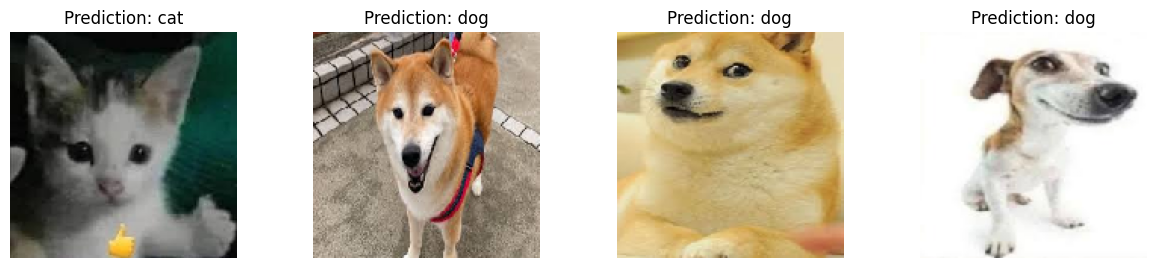

In [ ]:
import matplotlib.pyplot as plt
import os

# Caminho para o diretório contendo as imagens de teste
test_images_path = '/content/'  # Coloque o caminho correto para suas imagens de teste

# Listar os arquivos no diretório de imagens de teste
test_image_files = os.listdir(test_images_path)

# Filtrar apenas arquivos de imagem (se necessário)
test_image_files = [file for file in test_image_files if file.endswith('.jpeg')]

# Carregar as imagens de teste e fazer previsões
test_images = []
for image_file in test_image_files:
    # Caminho completo da imagem
    image_path = os.path.join(test_images_path, image_file)

    # Carregar a imagem
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_width, img_height))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image / 255.0  # Normalizar a imagem

    # Adicionar a imagem ao conjunto de testes
    test_images.append(image)

test_images = np.array(test_images)

# Fazer previsões usando o modelo
predictions = model.predict(test_images)

# Mapear os resultados para classes
class_names = ['cat', 'dog']

# Plotar as imagens com os resultados das previsões
plt.figure(figsize=(15, 10))
for i in range(len(test_images)):
    plt.subplot(3, 4, i + 1)
    plt.imshow(test_images[i])
    plt.title('Prediction: {}'.format(class_names[int(predictions[i] > 0.5)]))
    plt.axis('off')
plt.show()
